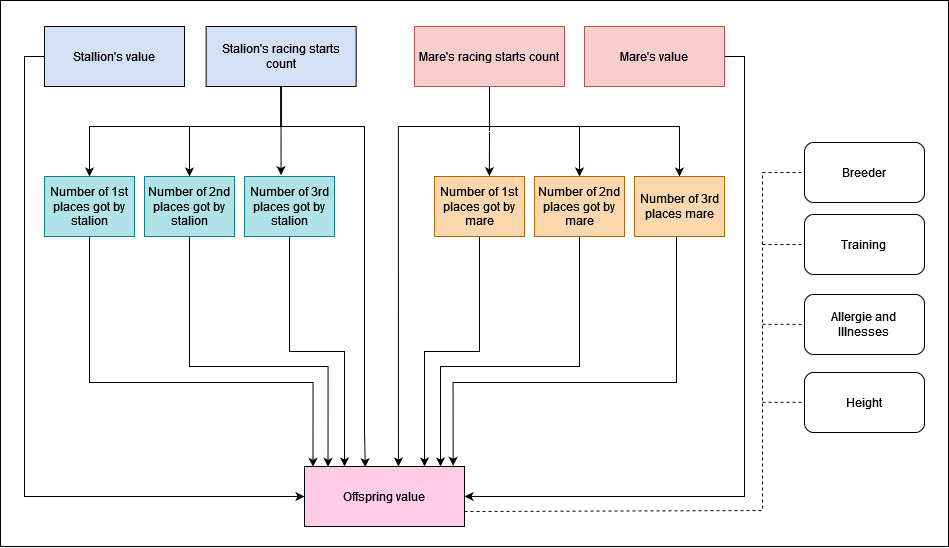

In [1]:
from PIL import Image
image = Image.open("OFFSPRING_DAG.jpg")
display(image)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import scipy
from cmdstanpy import CmdStanModel
from cmdstanpy import install_cmdstan

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
path_to_prepared_data = 'data/data_prepared/prepared_horses.csv'
df = pd.read_csv(path_to_prepared_data)
df_no_nan = df.dropna().reset_index()
df_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              68 non-null     int64  
 1   Unnamed: 0         68 non-null     int64  
 2   kid_id             68 non-null     int64  
 3   mum_id             68 non-null     object 
 4   dad_id             68 non-null     object 
 5   value_numeric      68 non-null     float64
 6   sex                68 non-null     object 
 7   dad_value_numeric  68 non-null     float64
 8   dad_first_place    68 non-null     float64
 9   dad_second_place   68 non-null     float64
 10  dad_third_place    68 non-null     float64
 11  dad_num_of_starts  68 non-null     float64
 12  mum_value_numeric  68 non-null     float64
 13  mum_first_place    68 non-null     float64
 14  mum_second_place   68 non-null     float64
 15  mum_third_place    68 non-null     float64
 16  mum_num_of_starts  68 non-nu

In [35]:
sex_dict = {'S': 1, 'M': 1, 'F': 0}
df_no_nan.sex.map(sex_dict).info()


<class 'pandas.core.series.Series'>
RangeIndex: 68 entries, 0 to 67
Series name: sex
Non-Null Count  Dtype
--------------  -----
68 non-null     int64
dtypes: int64(1)
memory usage: 672.0 bytes


In [43]:
from sklearn.preprocessing import StandardScaler

# rescaling values
df_copy = df_no_nan.drop(['kid_id', 'mum_id', 'dad_id', 'Unnamed: 0', 'sex', 'value_numeric'], axis=1)
columns_names = df_copy.columns
scaler = StandardScaler()
scaler.fit(df_copy)
df_copy = pd.DataFrame(scaler.transform(df_copy))
df_copy.columns = columns_names
df_copy['sex'] = df_no_nan.sex.map(sex_dict)
df_copy['value_numeric'] = df_no_nan['value_numeric']/(10**6)

# x - mu
# ------
#  sig

df_copy.head()

,index,dad_value_numeric,dad_first_place,dad_second_place,dad_third_place,dad_num_of_starts,mum_value_numeric,mum_first_place,mum_second_place,mum_third_place,mum_num_of_starts,sex,value_numeric
0,-1.592089,-0.785413,-0.674433,-0.942679,-0.772553,-0.917248,-0.167345,0.249083,0.409922,0.682997,0.085781,1,0.132570
1,-1.549483,-0.785413,-0.674433,-0.942679,-0.772553,-0.917248,-0.167345,0.249083,0.409922,0.682997,0.085781,0,0.030739
2,-1.506877,3.436815,3.755368,1.106249,0.678651,2.008112,-0.167345,0.249083,0.409922,0.682997,0.085781,1,0.631605
3,-1.464271,0.339120,-0.022992,-0.649975,-0.192071,-0.499339,-0.167345,0.249083,0.409922,0.682997,0.085781,1,0.008963
4,-1.421665,0.339120,-0.022992,-0.649975,-0.192071,-0.499339,-0.167345,0.249083,0.409922,0.682997,0.085781,1,0.004799


# Data exploration



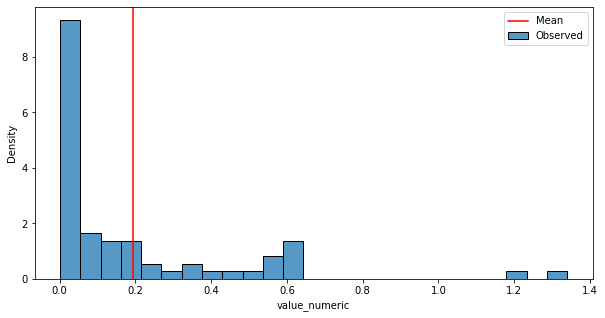

In [44]:
fig, axs = plt.subplots(1,1, figsize=(10,5))
graph = sns.histplot(data=df_copy, x='value_numeric', bins=25, ax=axs, label='Observed',stat='density')
graph.axvline(df_copy.value_numeric.mean(), color='red', label='Mean')
graph.legend()
plt.show()

# Model 1

## Prior Predictive Check

In [263]:
model_ppc1=CmdStanModel(stan_file='models/v2_model1_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/v2_model1_ppc.stan to exe file /home/racehorse_bayes/models/v2_model1_ppc
INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/v2_model1_ppc


In [264]:
data = { 'N': len(df_copy),
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts
         }

sim_ppc1 = model_ppc1.sample(data=data, 
                        iter_sampling=1000,
                        iter_warmup=0, 
                        chains=1, 
                        fixed_param=True,
                        # show_console=True,
                        seed=20230613)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [265]:
sim_ppc1_df = sim_ppc1.draws_pd()
sim_ppc1_df.head()

,lp__,accept_stat__,dad_ns_coef,dad_fp_coef,dad_sp_coef,dad_tp_coef,dad_val_coef,mum_ns_coef,mum_fp_coef,mum_sp_coef,...,output[59],output[60],output[61],output[62],output[63],output[64],output[65],output[66],output[67],output[68]
0,0.0,0.0,-0.304634,-0.354504,0.136220,0.347574,0.006887,0.257142,-0.048270,-0.160676,...,1.435080e-03,171.701000,8.227330e+00,1.370960e-01,3.111310e+01,4.190540e+03,1.491540e-04,5.687630e+03,9.444580e-03,0.039380
1,0.0,0.0,-0.152502,-0.217005,-0.087212,-0.465658,-0.105448,-0.396894,0.045998,0.488346,...,3.241010e+07,41.022900,3.439360e+10,2.884150e-04,3.011830e+11,3.146920e-01,5.794720e-11,3.414030e+12,6.172660e-01,2.195820
2,0.0,0.0,0.099383,-0.513015,0.643032,0.274804,0.065112,-0.203932,-0.025541,-0.178153,...,1.672260e+01,0.097914,4.661480e+02,1.577890e-03,5.182010e+01,5.995610e-01,2.126160e+03,3.505290e-01,3.297070e-02,1.917680
3,0.0,0.0,-0.074955,-0.205452,-0.378234,-0.804714,0.057341,-0.178150,0.400882,0.097183,...,2.680610e-02,115.410000,1.348730e-01,2.093310e+01,3.359510e+02,4.626540e-08,5.761180e+04,4.488650e-06,5.393580e-08,0.000027
4,0.0,0.0,-0.452171,-0.083522,0.536916,0.111460,-0.458669,0.002754,-0.212660,0.063571,...,3.633110e-01,0.001134,3.894550e+01,2.390630e+08,4.240630e-01,9.048830e+05,2.707980e+02,1.463340e-04,1.933760e+02,0.001913


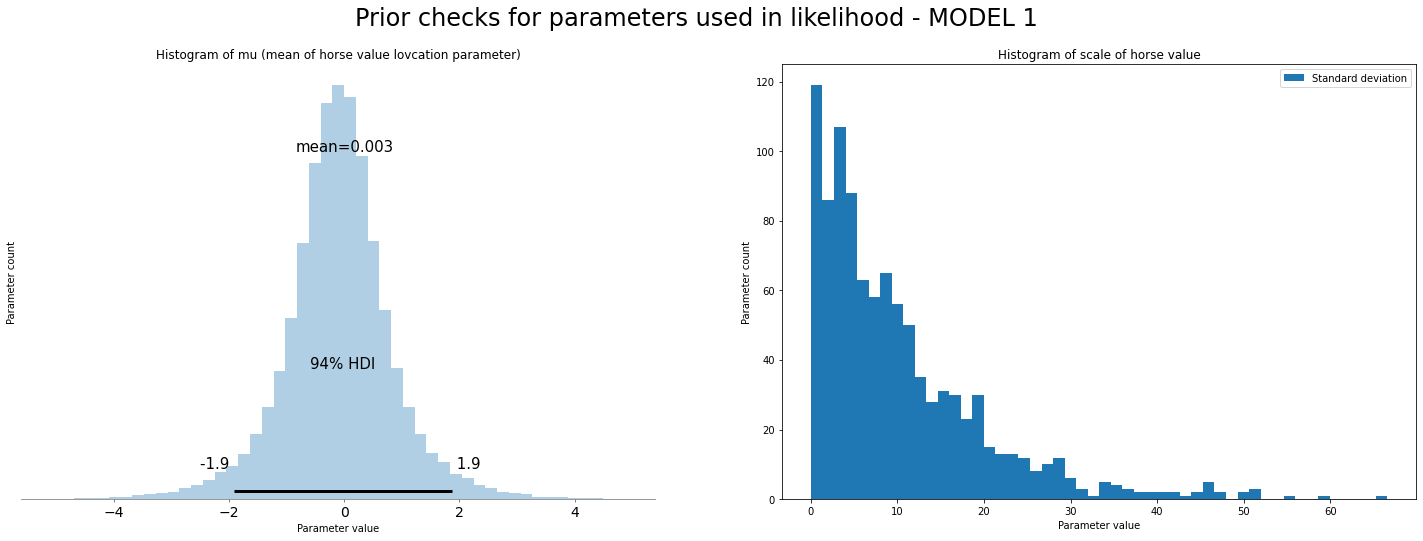

In [268]:
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Prior checks for parameters used in likelihood - MODEL 1", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model1_ppc_mu = sim_ppc1.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model1_ppc_mu, kind='hist', ax=ax1[0], bins=np.linspace(-5,5,50), group='prior', log=False)
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of horse value lovcation parameter)")

# get meal_prep_coeff coeff
model1_ppc_sigma = sim_ppc1.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model1_ppc_sigma,label="Standard deviation", bins=50)
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of scale of horse value")
plt.show()


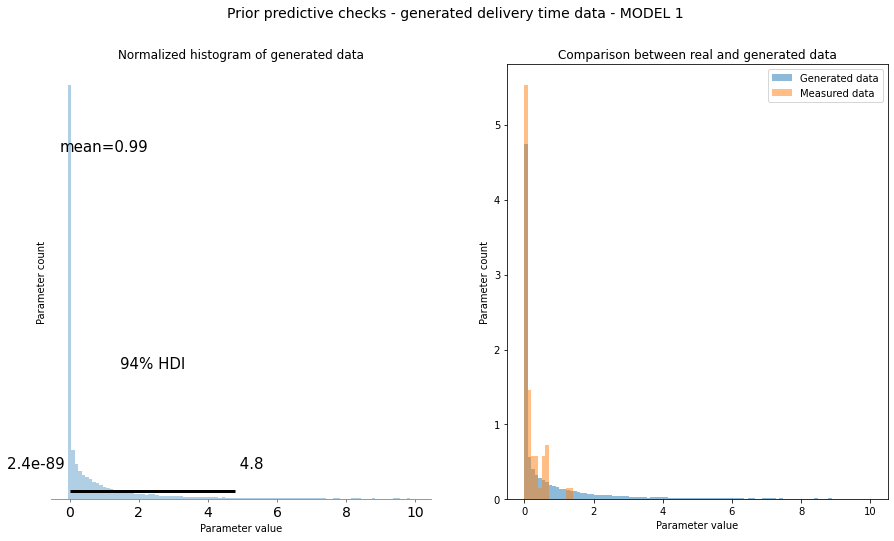

In [267]:
fig2, ax2= plt.subplots(1,2, figsize=(15,8))
fig2.suptitle("Prior predictive checks - generated delivery time data - MODEL 1", fontsize=14)

# get measurements
model1_ppc_measurements = sim_ppc1.stan_variable('output').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 10, 100)

az.plot_posterior(model1_ppc_measurements[model1_ppc_measurements<10], kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib", log=False)
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# # plot measurements
ax2[1].hist(model1_ppc_measurements[model1_ppc_measurements<10], density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(df_copy['value_numeric'], density=True, bins=bins, alpha=0.5, label="Measured data", log=False)
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()


## Posterior check

In [270]:
model1_posterior = model_ppc1=CmdStanModel(stan_file='models/v2_model1_post.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/v2_model1_post.stan to exe file /home/racehorse_bayes/models/v2_model1_post
INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/v2_model1_post


In [273]:
data = { 'N': len(df_copy),
        'output': df_copy.value_numeric,
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts
         }

sim_post1 = model1_posterior.sample(data=data, 
                        iter_sampling=1000,
                        iter_warmup=0, 
                        chains=1, 
                        fixed_param=True,
                        # show_console=True,
                        seed=20230613)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [274]:
sim_post1_df = sim_post1.draws_pd()
sim_post1_df.head()

,lp__,accept_stat__,dad_ns_coef,dad_fp_coef,dad_sp_coef,dad_tp_coef,dad_val_coef,mum_ns_coef,mum_fp_coef,mum_sp_coef,...,log_likelyhood[59],log_likelyhood[60],log_likelyhood[61],log_likelyhood[62],log_likelyhood[63],log_likelyhood[64],log_likelyhood[65],log_likelyhood[66],log_likelyhood[67],log_likelyhood[68]
0,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,0.371536,-17.6693,-40.0638,-0.571657,-0.048561,-16.2068,-7.79077,-1.27065,-3.78095,-23.0498
1,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,0.371536,-17.6693,-40.0638,-0.571657,-0.048561,-16.2068,-7.79077,-1.27065,-3.78095,-23.0498
2,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,0.371536,-17.6693,-40.0638,-0.571657,-0.048561,-16.2068,-7.79077,-1.27065,-3.78095,-23.0498
3,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,0.371536,-17.6693,-40.0638,-0.571657,-0.048561,-16.2068,-7.79077,-1.27065,-3.78095,-23.0498
4,0.0,0.0,1.52024,-1.86181,0.741953,-0.143759,-0.008348,-0.699751,1.64419,0.749263,...,0.371536,-17.6693,-40.0638,-0.571657,-0.048561,-16.2068,-7.79077,-1.27065,-3.78095,-23.0498


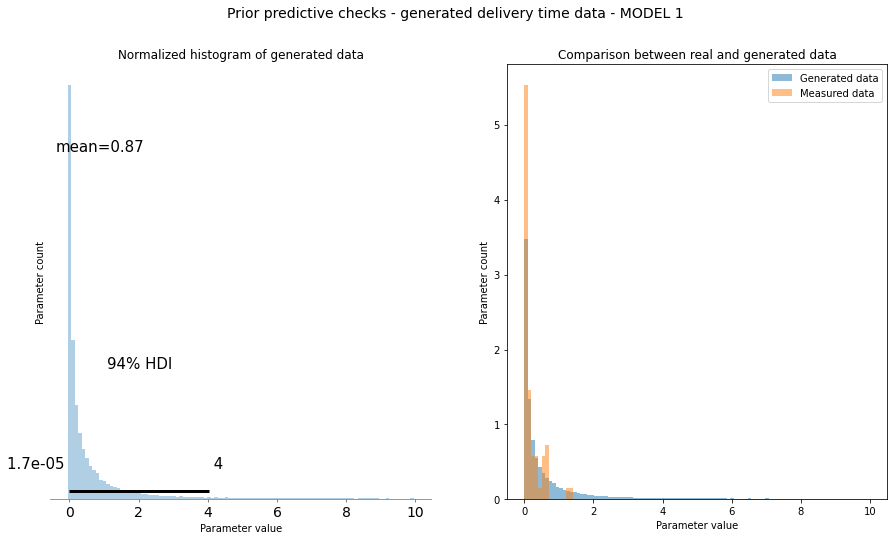

In [275]:
fig2, ax2= plt.subplots(1,2, figsize=(15,8))
fig2.suptitle("Prior predictive checks - generated delivery time data - MODEL 1", fontsize=14)

# get measurements
model1_ppc_measurements = sim_post1.stan_variable('output_pred').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 10, 100)

az.plot_posterior(model1_ppc_measurements[model1_ppc_measurements<10], kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib", log=False)
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# # plot measurements
ax2[1].hist(model1_ppc_measurements[model1_ppc_measurements<10], density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(df_copy['value_numeric'], density=True, bins=bins, alpha=0.5, label="Measured data", log=False)
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()

Posterior works better than prior! This is promising

# Model 1.1

Different coeficients depending on sex


## Prior


In [281]:
model1_1_ppc = CmdStanModel(stan_file='models/v2_model1_1_ppc.stan')

INFO:cmdstanpy:compiling stan file /home/racehorse_bayes/models/v2_model1_1_ppc.stan to exe file /home/racehorse_bayes/models/v2_model1_1_ppc
INFO:cmdstanpy:compiled model executable: /home/racehorse_bayes/models/v2_model1_1_ppc


In [285]:
data = { 'N': len(df_copy),
        'horse_sex': df_copy.sex + 1,
        'dad_val': df_copy.dad_value_numeric,
        'dad_ns': df_copy.dad_num_of_starts,
        'dad_fp': df_copy.dad_first_place,
        'dad_sp': df_copy.dad_second_place,
        'dad_tp': df_copy.dad_third_place,
        'mum_val': df_copy.mum_value_numeric,
        'mum_fp': df_copy.mum_first_place,
        'mum_sp': df_copy.mum_second_place,
        'mum_tp': df_copy.mum_third_place,
        'mum_ns': df_copy.mum_num_of_starts
         }

sim_ppc1_1 = model1_1_ppc.sample(data=data, 
                        iter_sampling=1000,
                        iter_warmup=0, 
                        chains=1, 
                        fixed_param=True,
                        show_console=True,
                        seed=20230613)

INFO:cmdstanpy:Chain [1] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 1000 (Default)
Chain [1] num_warmup = 0
Chain [1] save_warmup = 0 (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = 1 (Default)
Chain [1] gamma = 0.050000000000000003 (Default)
Chain [1] delta = 0.80000000000000004 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] algorithm = fixed_param
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmpvj26fn2l/wz60z8dl.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 20230613
Chain [1] output
Chain [1] file = /tmp/tmpvj26fn2l/v2_model1_1_ppc-20230714073816.csv
Chain [1] diagnostic_file =  (Default)
Chain [1] refresh = 100 (Default)
Chain [1] sig_figs = -1 (Default)
Chain [1] profile_file = profile.csv (Default)
Chain [1] num_threads = 1 (Default)

INFO:cmdstanpy:Chain [1] done processing


Chain [1] Iteration: 1000 / 1000 [100%]  (Sampling)
Chain [1] 
Chain [1]  Elapsed Time: 0 seconds (Warm-up)
Chain [1]                0.699 seconds (Sampling)
Chain [1]                0.699 seconds (Total)
Chain [1] 
Chain [1] 


In [286]:
sim_ppc1_1_df = sim_ppc1_1.draws_pd()
sim_ppc1_1_df.head()

,lp__,accept_stat__,dad_ns_coef[1],dad_ns_coef[2],dad_fp_coef[1],dad_fp_coef[2],dad_sp_coef[1],dad_sp_coef[2],dad_tp_coef[1],dad_tp_coef[2],...,output[59],output[60],output[61],output[62],output[63],output[64],output[65],output[66],output[67],output[68]
0,0.0,0.0,-0.304634,-0.354504,0.136220,0.347574,0.006887,0.257142,-0.048270,-0.160676,...,2.480130e-06,7.353890e-09,0.002709,7.888450e-18,0.000362,1.063580e-14,48.681600,1.036320e+18,0.000583,5.681250e-12
1,0.0,0.0,-0.160966,-0.284775,0.048959,-0.501571,-0.027574,-0.045703,0.224389,-0.157122,...,6.370440e-01,6.729470e-01,2.860530,5.112460e+00,0.077102,9.682990e+00,0.007006,1.048860e+02,0.001233,1.227260e-04
2,0.0,0.0,-0.131653,-0.696113,0.082827,0.707624,0.332839,0.048010,-0.433654,0.131700,...,3.534400e-02,2.040690e+02,0.006135,6.581650e-04,0.000035,7.875070e-01,0.000093,1.039810e+03,73.335600,3.060580e+00
3,0.0,0.0,0.439395,0.211564,-0.297887,-0.280326,-0.149482,0.482187,0.154316,-0.282449,...,5.336920e+00,6.770540e-01,1.667530,1.434530e-01,10.777200,9.375560e-01,59.761200,3.886470e-03,0.083692,7.961630e-02
4,0.0,0.0,-0.104916,-0.317986,-0.218657,0.181223,-0.441622,-0.040696,0.027026,-0.541111,...,3.522970e-30,1.212240e-12,1.543930,6.517660e+07,51.233300,2.655200e+09,0.000018,2.963440e+01,26893.200000,1.152300e+01


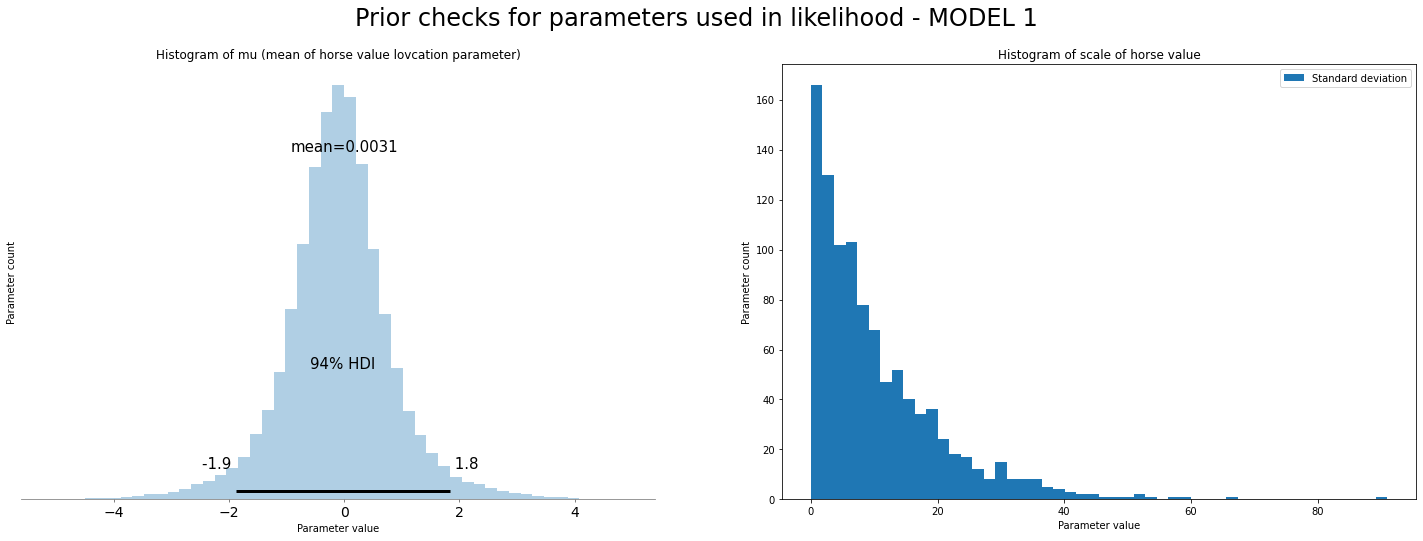

In [288]:
fig1, ax1= plt.subplots(1,2, figsize=(25,8))
fig1.suptitle("Prior checks for parameters used in likelihood - MODEL 1", fontsize=24)

# get distance coeff (flatten because its MxN matrix (data samples x algo samples))
model1_ppc_mu = sim_ppc1_1.stan_variable('mu').flatten()

# plot distance coeff
az.plot_posterior(model1_ppc_mu, kind='hist', ax=ax1[0], bins=np.linspace(-5,5,50), group='prior', log=False)
ax1[0].set_frame_on(True)
ax1[0].set_xlabel("Parameter value")
ax1[0].set_ylabel("Parameter count")
ax1[0].set_title("Histogram of mu (mean of horse value lovcation parameter)")

# get meal_prep_coeff coeff
model1_ppc_sigma = sim_ppc1_1.stan_variable('sigma')

# plot meal_prep_coeff coeff
ax1[1].hist(model1_ppc_sigma,label="Standard deviation", bins=50)
ax1[1].legend()
ax1[1].set_xlabel("Parameter value")
ax1[1].set_ylabel("Parameter count")
ax1[1].set_title("Histogram of scale of horse value")
plt.show()

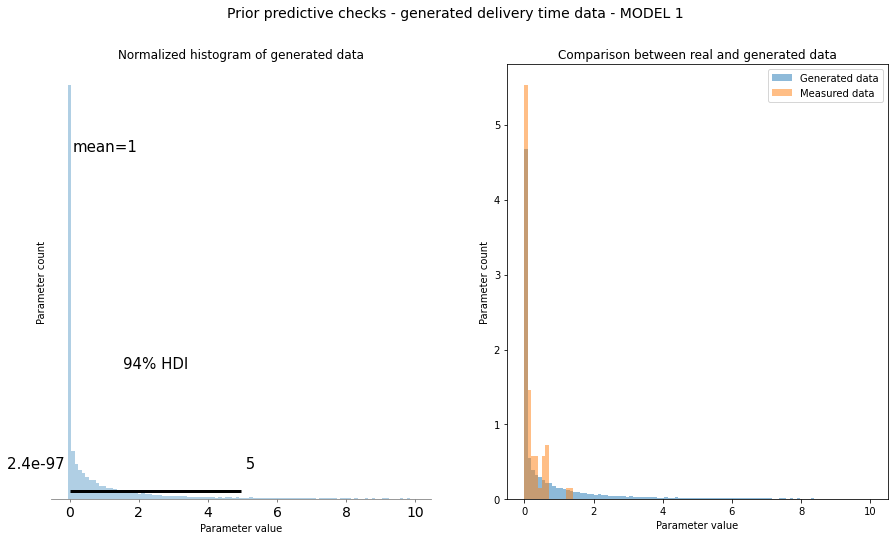

In [290]:
fig2, ax2= plt.subplots(1,2, figsize=(15,8))
fig2.suptitle("Prior predictive checks - generated delivery time data - MODEL 1", fontsize=14)

# get measurements
model1_ppc_measurements = sim_ppc1_1.stan_variable('output').flatten()  # flatten makes it row/column vector (one of these)

# set bins
bins = np.linspace(0, 10, 100)

az.plot_posterior(model1_ppc_measurements[model1_ppc_measurements<10], kind='hist', ax=ax2[0], bins=bins, group='prior', backend="matplotlib", log=False)
ax2[0].set_xlabel("Parameter value")
ax2[0].set_ylabel("Parameter count")
ax2[0].set_title("Normalized histogram of generated data")

# # plot measurements
ax2[1].hist(model1_ppc_measurements[model1_ppc_measurements<10], density=True, bins=bins,  alpha=0.5, label="Generated data")

# compare with real data, density set to True because each data point sampled 999 times
ax2[1].hist(df_copy['value_numeric'], density=True, bins=bins, alpha=0.5, label="Measured data", log=False)
ax2[1].legend()
ax2[1].set_xlabel("Parameter value")
ax2[1].set_ylabel("Parameter count")
ax2[1].set_title("Comparison between real and generated data")
plt.show()

## TODO Posterior analysis